# Mall Customer Segmentation - Сегментация клиентов торгового центра

## Fields
* CustomerID - уникальный идентификатор
* Gender - пол
* Age - возраст
* Annual Income (k$) - годовой доход в тысячах долларов
* Spending Score (1-100) - оценка расходов по шкале от 1 до 100

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN

In [190]:
df = pd.read_csv('Mall_Customers.csv')

In [191]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [192]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

Упростим названия столбцов

In [193]:
rename_columns = {
    'CustomerID': 'id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income',
    'Spending Score (1-100)': 'spending_score'
}
df.rename(columns=rename_columns, inplace=True)
df.drop(columns=['id'], inplace=True)
df.head()

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [195]:
numeric_fields = ['age', 'annual_income', 'spending_score']
df[numeric_fields].describe().loc[['min', 'max', 'mean', 'std']]

,age,annual_income,spending_score
min,18.000000,15.000000,1.000000
max,70.000000,137.000000,99.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522


In [196]:
category_fields = ['gender']
df[category_fields].describe()

,gender
count,200
unique,2
top,Female
freq,112


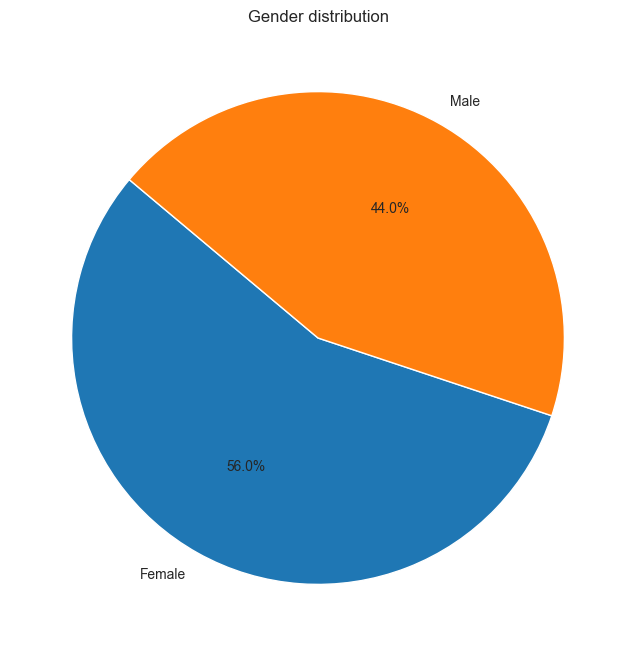

In [197]:
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 8))
plt.title('Gender distribution')
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.show()

C:\Users\ilyar\AppData\Local\Temp\ipykernel_20196\1904639818.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
C:\Users\ilyar\AppData\Local\Temp\ipykernel_20196\1904639818.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

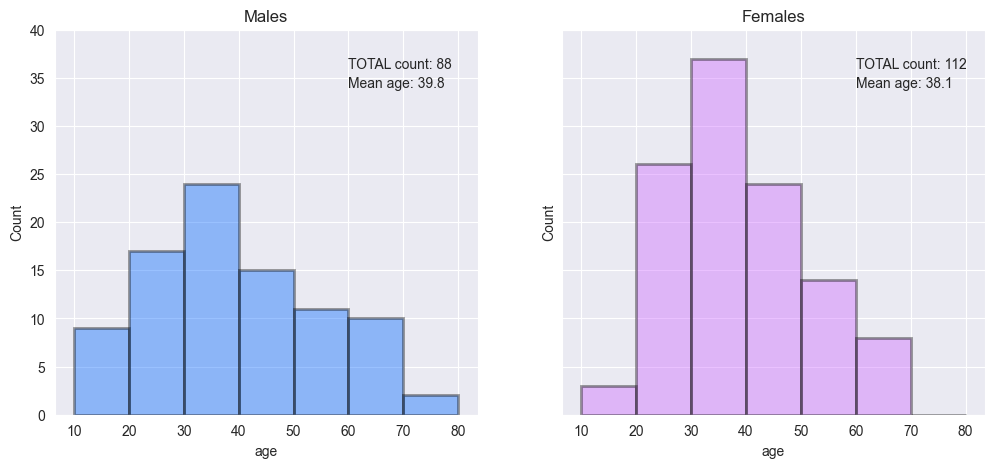

In [198]:
males_age = df[df['gender']=='Male']['age']
females_age = df[df['gender']=='Female']['age']

bins = np.arange(10, 81, 10)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(bins)
ax1.set_ylim(top=40)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(60,36, "TOTAL count: {}".format(males_age.count()))
ax1.text(60,34, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(60,36, "TOTAL count: {}".format(females_age.count()))
ax2.text(60,34, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

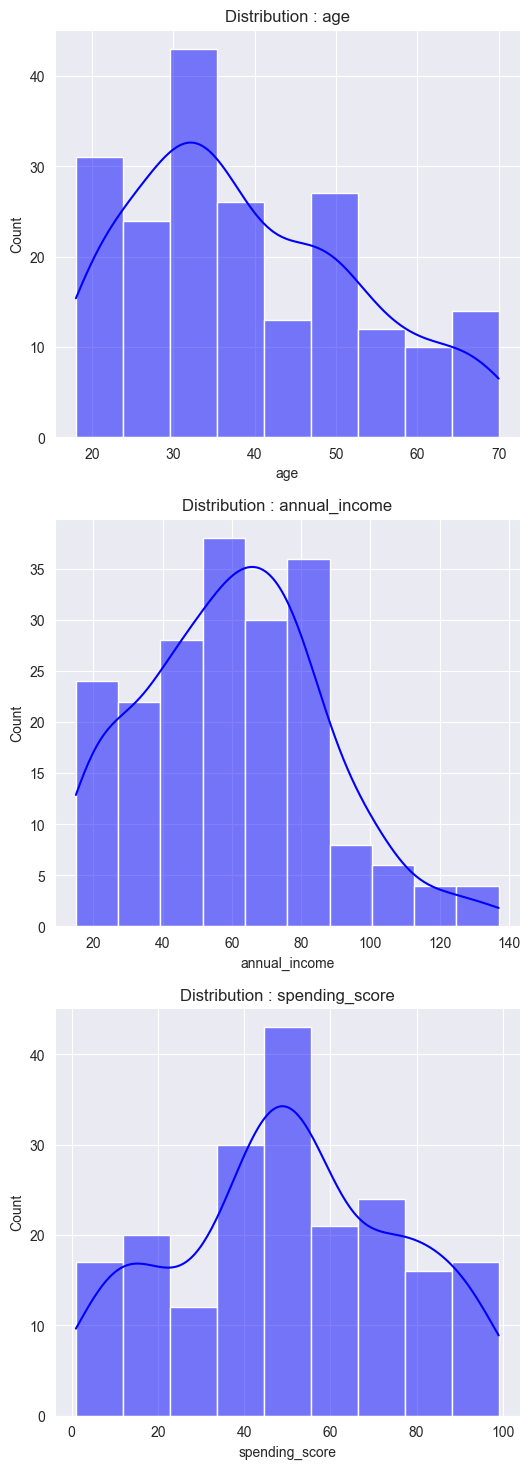

In [199]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (6,18))
for i in range(len(numeric_fields)):
    plt.subplot(3,1,i+1)
    sns.histplot(df[numeric_fields[i]], kde=True, color='blue', ax=ax[i])
    title = 'Distribution : ' + numeric_fields[i]
    plt.title(title)
plt.show()

Кластеризация KMeans

In [200]:
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})


C:\Users\ilyar\AppData\Local\Temp\ipykernel_20196\1267485270.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})


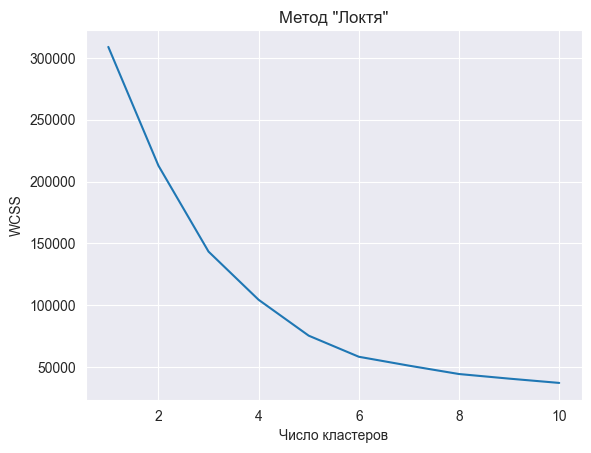

In [201]:
# Список для хранения WCSS (сумма квадратов расстояний внутри кластера)
wcss = []

# Применим k-средних для k от 1 до 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Визуализация результатов
plt.plot(range(1, 11), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

Метод "Локтя" показывает, что оптимальное количество кластеров - 6

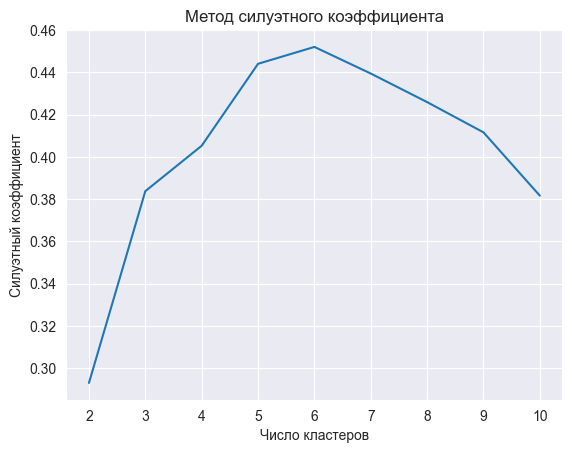

In [202]:
# Список для хранения силуэтных коэффициентов
silhouette_coefficients = []

# Начинаем с минимума 2 кластеров, так как для одного кластера силуэтный коэффициент не определен
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

# Визуализация результатов
plt.plot(range(2, 11), silhouette_coefficients)
plt.title('Метод силуэтного коэффициента')
plt.xlabel('Число кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.show()

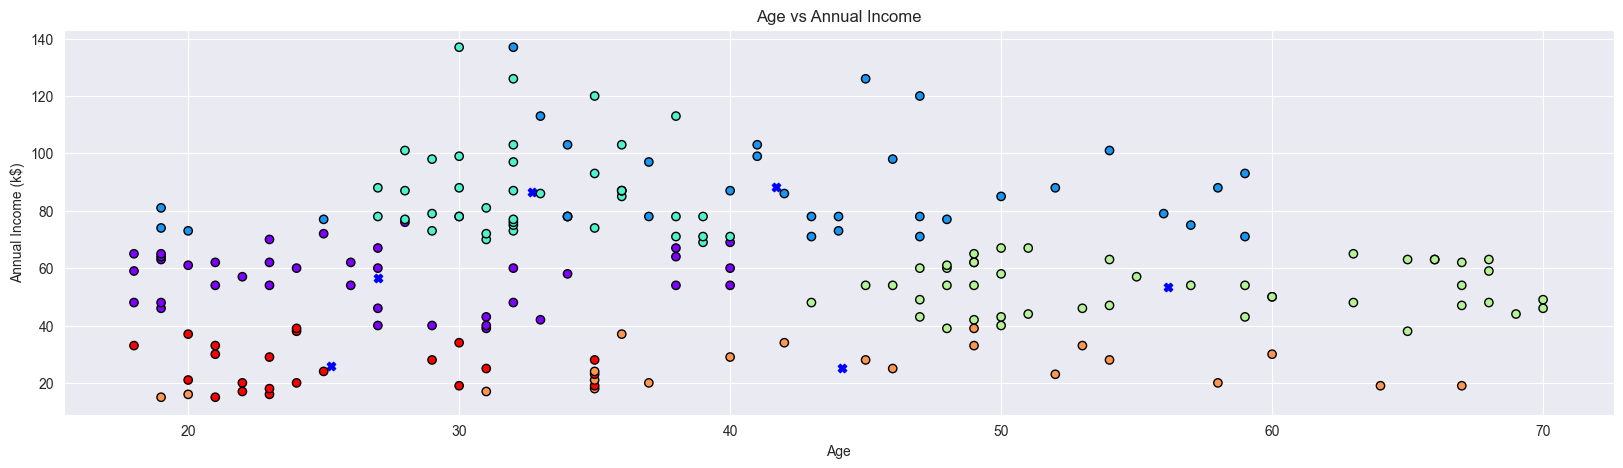

In [203]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df)
cluster = kmeans.cluster_centers_
centroids = np.array(cluster)
labels = kmeans.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,1],centroids[:,2], marker = "X", color = 'b')
plt.scatter(x = 'age',y = 'annual_income',c = labels,cmap = 'rainbow',data = df,edgecolor = 'black');
plt.title('Age vs Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show();

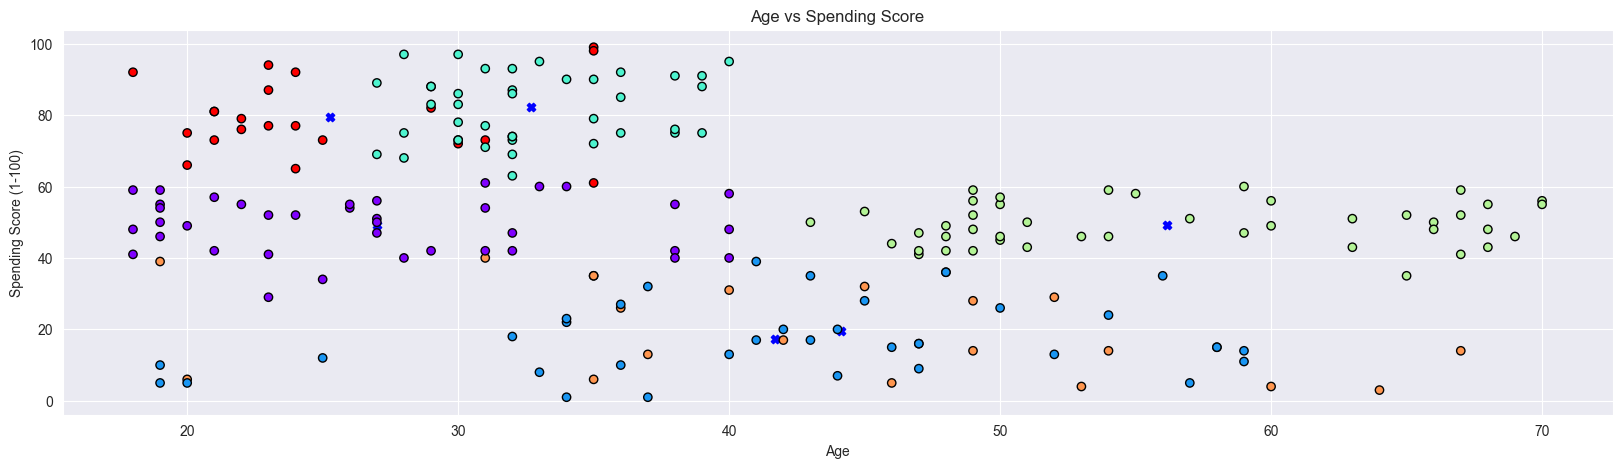

In [204]:
plt.figure(figsize = (20,5))
plt.scatter(centroids[:,1],centroids[:,3], marker = "X", color = 'b')
plt.scatter(x = 'age',y = 'spending_score',c = labels,cmap = 'rainbow',data = df,edgecolor = 'black');
plt.title('Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show();

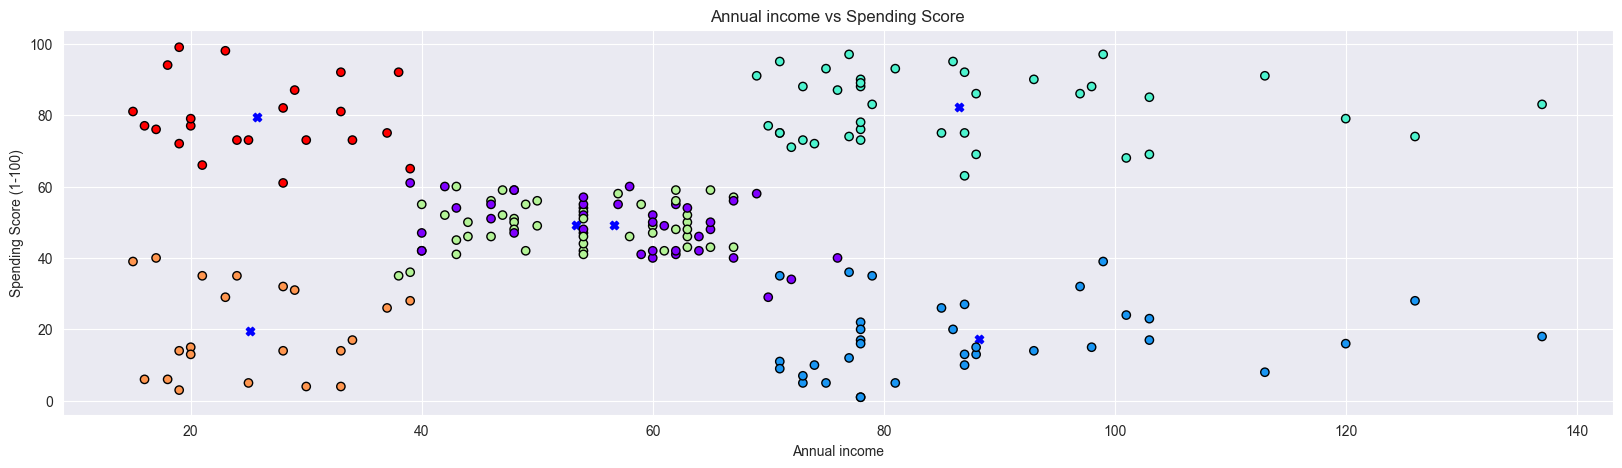

In [205]:
plt.figure(figsize = (20,5))
plt.scatter(centroids[:,2],centroids[:,3], marker = "X", color = 'b')
plt.scatter(x = 'annual_income',y = 'spending_score',c = labels,cmap = 'rainbow',data = df,edgecolor = 'black');
plt.title('Annual income vs Spending Score')
plt.xlabel('Annual income')
plt.ylabel('Spending Score (1-100)')
plt.show();

Этот график очень интересный - можно заметить 5 четко выделенных групп, каждой соответствует свой кластер, кроме центральной, где выделяются 2 кластера:
1. Кластер с низким годовым доходом и низкими расходами
2. Кластер с низким годовым доходом и высокими расходами
3. Кластер со средним годовым доходом и средними расходами (1) - судя по графику выше, до 40 лет
4. Кластер со средним годовым доходом и средними расходами (2) - судя по графику выше, после 40 лет
5. Кластер с высоким годовым доходом и низкими расходами
6. Кластер с высоким годовым доходом и высокими расходами

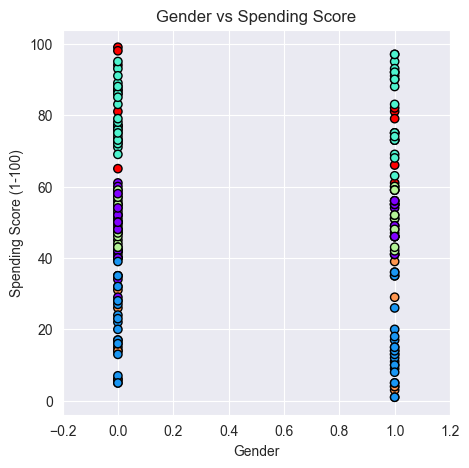

In [206]:
plt.figure(figsize = (5,5))
plt.scatter(centroids[:,2],centroids[:,3], marker = "X", color = 'b')
plt.scatter(x = 'gender',y = 'spending_score',c = labels,cmap = 'rainbow',data = df,edgecolor = 'black')
plt.title('Gender vs Spending Score')
plt.xlabel('Gender')
plt.xlim(-0.2,1.2)
plt.ylabel('Spending Score (1-100)')
plt.show();

Судя по последнему графику, половое различие не сильно влияет на кластеризацию - представители обоих полов более-менее равномерно распределены по всем кластерам

# Иерархическая кластеризация

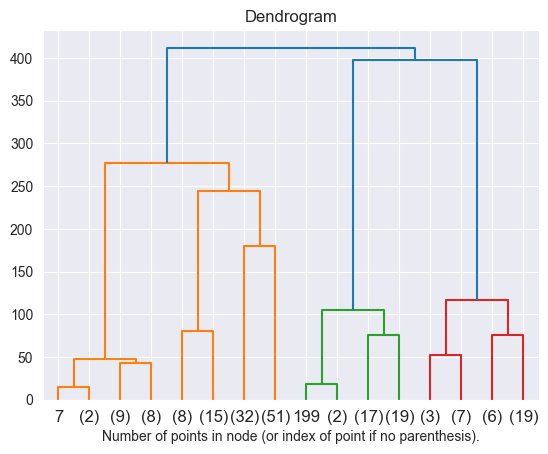

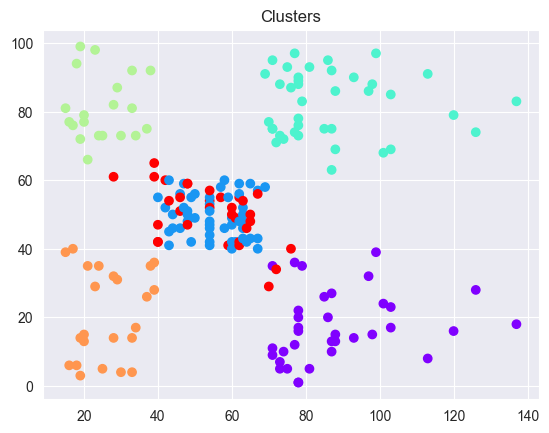

In [207]:

# Выполняем агломеративную иерархическую кластеризацию
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df)

# Функция для визуализации дендрограммы (используя scipy)
def plot_dendrogram(model, **kwargs):
    # Создаем связки для дендрограммы
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# Визуализация дендрограммы
plt.title('Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Если вы хотите визуализировать сами кластеры, вы можете также выполнить:
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(df)
plt.scatter(df['annual_income'], df['spending_score'], c=model.labels_, cmap='rainbow')
plt.title('Clusters')
plt.show()

Задать вопрос: по plot_dendrogram - как это работает? Что означают цвета и линии? Как регулируется количество кластеров в первом случае?

В остальном - иерархическая кластеризация показывает примерно те же результаты, что и KMeans

## DBSCAN

4 61


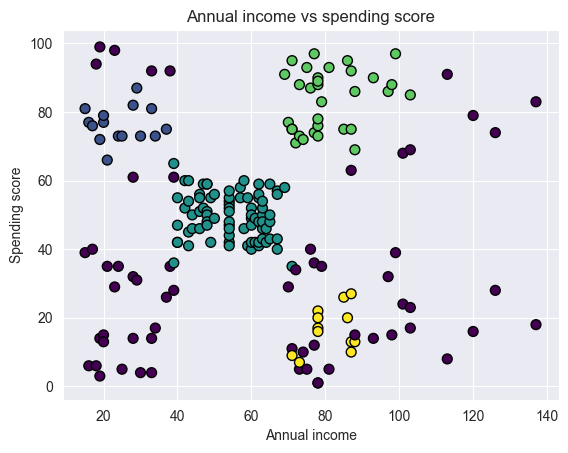

In [208]:
dbscan = DBSCAN(eps=12, min_samples=8)
clusters = dbscan.fit_predict(df)
labels = dbscan.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(n_clusters, n_noise)

plt.scatter(df['annual_income'], df['spending_score'], c=clusters, cmap="viridis", marker='o', edgecolor='black', s=50)
plt.title('Annual income vs spending score')
plt.xlabel('Annual income')
plt.ylabel('Spending score')
plt.show()

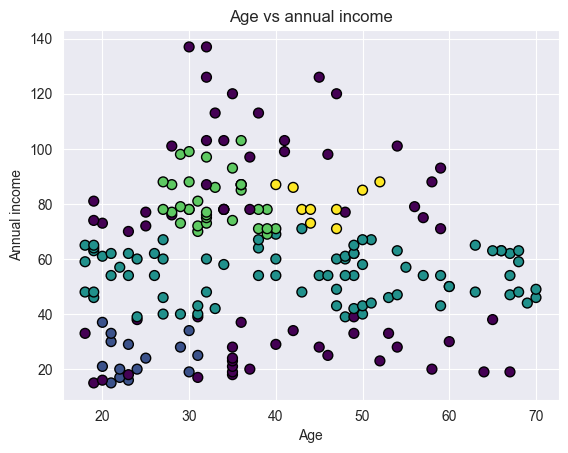

In [209]:
plt.scatter(df['age'], df['annual_income'], c=clusters, cmap="viridis", marker='o', edgecolor='black', s=50)
plt.title('Age vs annual income')
plt.xlabel('Age')
plt.ylabel('Annual income')
plt.show()

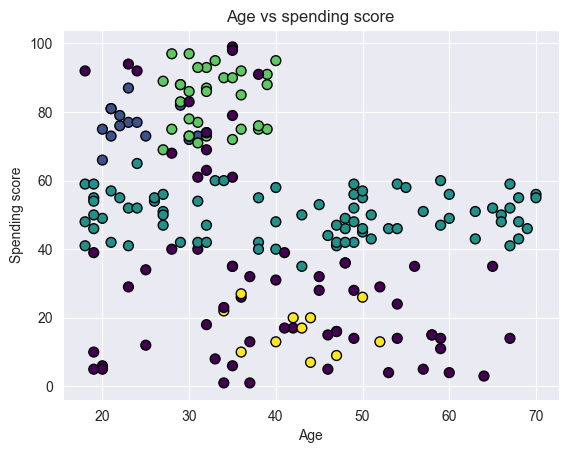

In [210]:
plt.scatter(df['age'], df['spending_score'], c=clusters, cmap="viridis", marker='o', edgecolor='black', s=50)
plt.title('Age vs spending score')
plt.xlabel('Age')
plt.ylabel('Spending score')
plt.show()

Вопрос: как подбирать параметры eps и min_samples?

Сделаем один график без шумовых точек

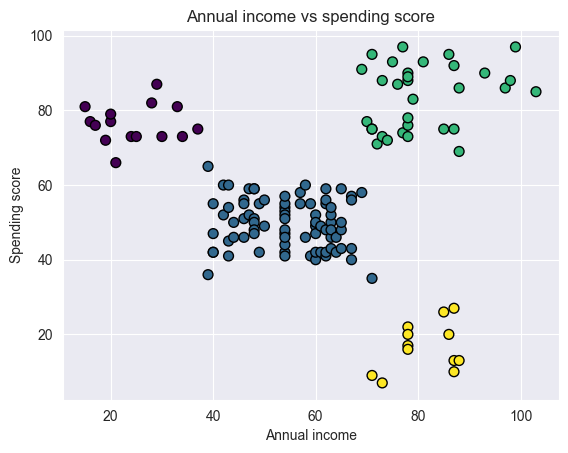

In [211]:
df['cluster'] = clusters
df_filtered = df[df['cluster'] != -1]
plt.scatter(df_filtered['annual_income'], df_filtered['spending_score'], c=df_filtered['cluster'], cmap="viridis", marker='o', edgecolor='black', s=50)
plt.title('Annual income vs spending score')
plt.xlabel('Annual income')
plt.ylabel('Spending score')
plt.show()

Кластеризация по методу DBSCAN имеет другое разделение по кластерам. Выделяется 4 кластера и 61 шумовая точка.